# This script served as visualitation for molecules reacting and the product predicted

## 1. Dependencies and dataset

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


import causallearn
from cdt.causality.graph import PC
from cdt.causality.graph import GES
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils


from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdFingerprintGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.Chem import Draw

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from causallearn.search.ConstraintBased.PC import pc


In [3]:
from scipy.stats import pearsonr

In [8]:
df_50k = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/USPTO_50k.csv')

In [5]:
df_full = pd.read_csv('/Users/davidsegura/git/Leveraging_LLMs_causality/USPTO_FULL.csv')

In [9]:
df_50k_react = df_50k.iloc[:, 2:] 

df_50k_split = df_50k_react['reactions'].str.split('>>', expand=True)

df_50k_split.columns = ['Reactant', 'Product']

df_50k_split[['Reactant 1', 'Reactant 2']] = df_50k_split['Reactant'].str.split('.', n=1, expand=True)

df_50k_split = df_50k_split.drop(columns=['Reactant'])

cols = list(df_50k_split.columns)

cols.append(cols.pop(0))

df_50k_split = df_50k_split[cols]

In [10]:
df_50k_split

,Reactant 1,Reactant 2,Product
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,None,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O
1,Nc1cccc2cnccc12,O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...
2,CCNCC,Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,O=C(CF)CF,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1,O=C(Cl)OC1CCCC1,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...
...,...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,None,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O,NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,None,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1


In [ ]:
matching_rows_df = pd.DataFrame()


for i, row_i in df_50k_split.iterrows():

    for j, row_j in df_50k_split.loc[i+1:].iterrows():

        if row_i['Reactant 1'] == row_j['Reactant 1'] and row_i['Reactant 2'] == row_j['Reactant 2']:
            
            matching_rows_df = pd.concat([matching_rows_df, pd.DataFrame([row_i]), pd.DataFrame([row_j])], ignore_index=True)


print(matching_rows_df)

## 2. Displaying the molecules

In [221]:
from IPython.display import display

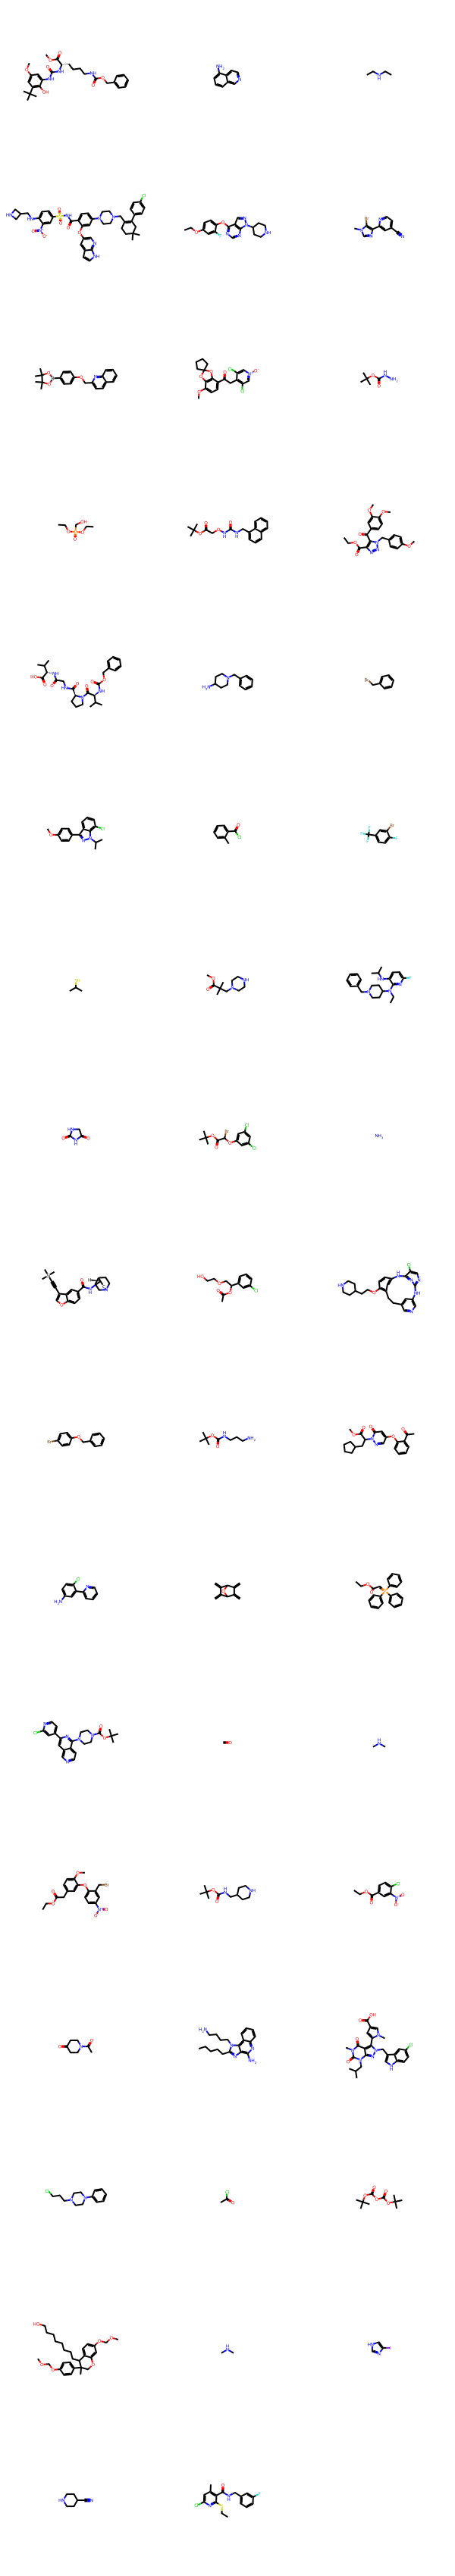

In [231]:
df_50k_split['Molecule 1'] = df_50k_split['Reactant 1'].apply(lambda x: Chem.MolFromSmiles(x))

# Visualize the molecules in 2D
mols = df_50k_split['Molecule'].tolist()  

# Display the molecules as a grid
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

display(img)

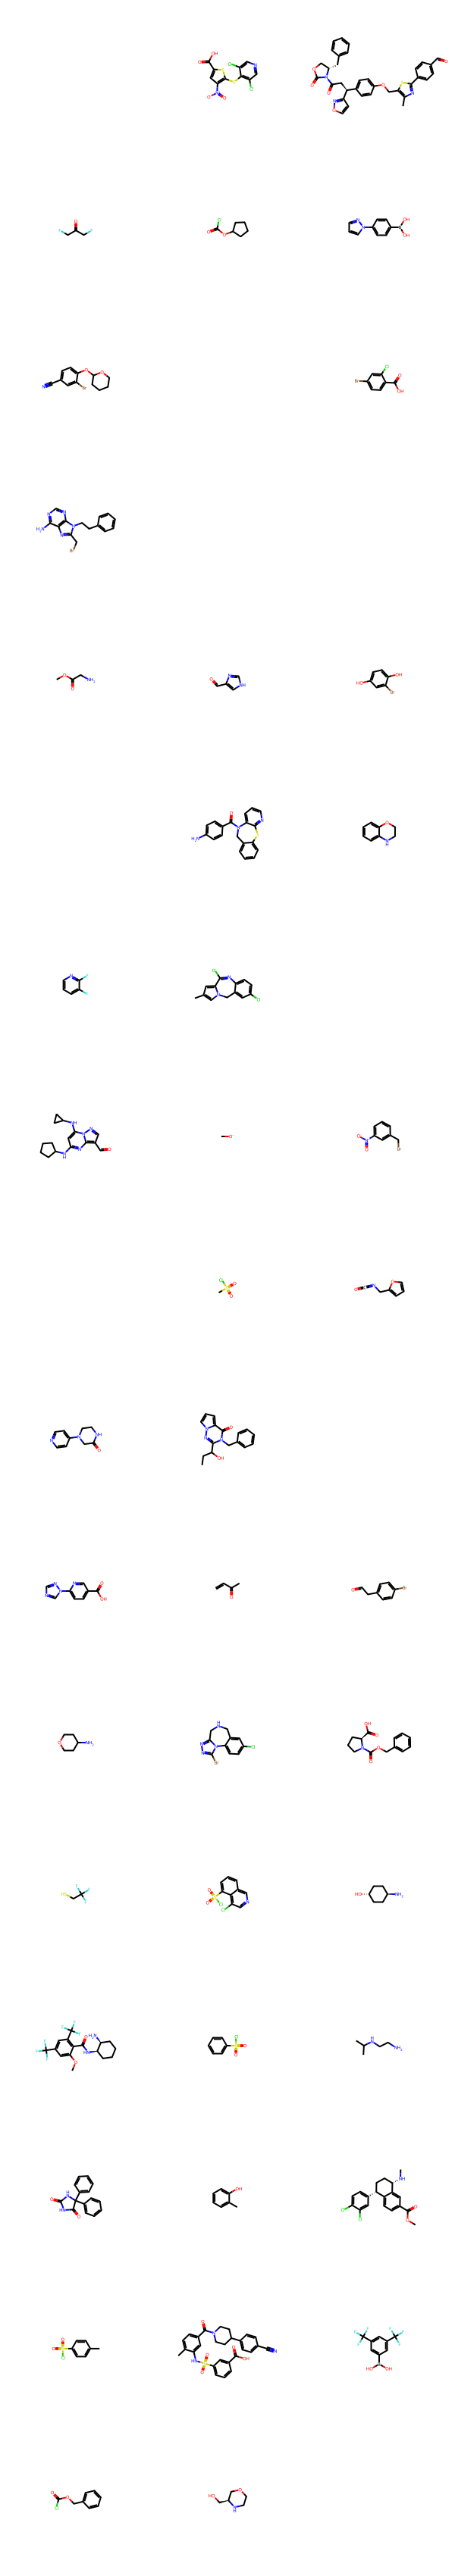

In [232]:
df_50k_split['Molecule 2'] = df_50k_split['Reactant 2'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

mols = df_50k_split['Molecule 2'].tolist()  

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

display(img)

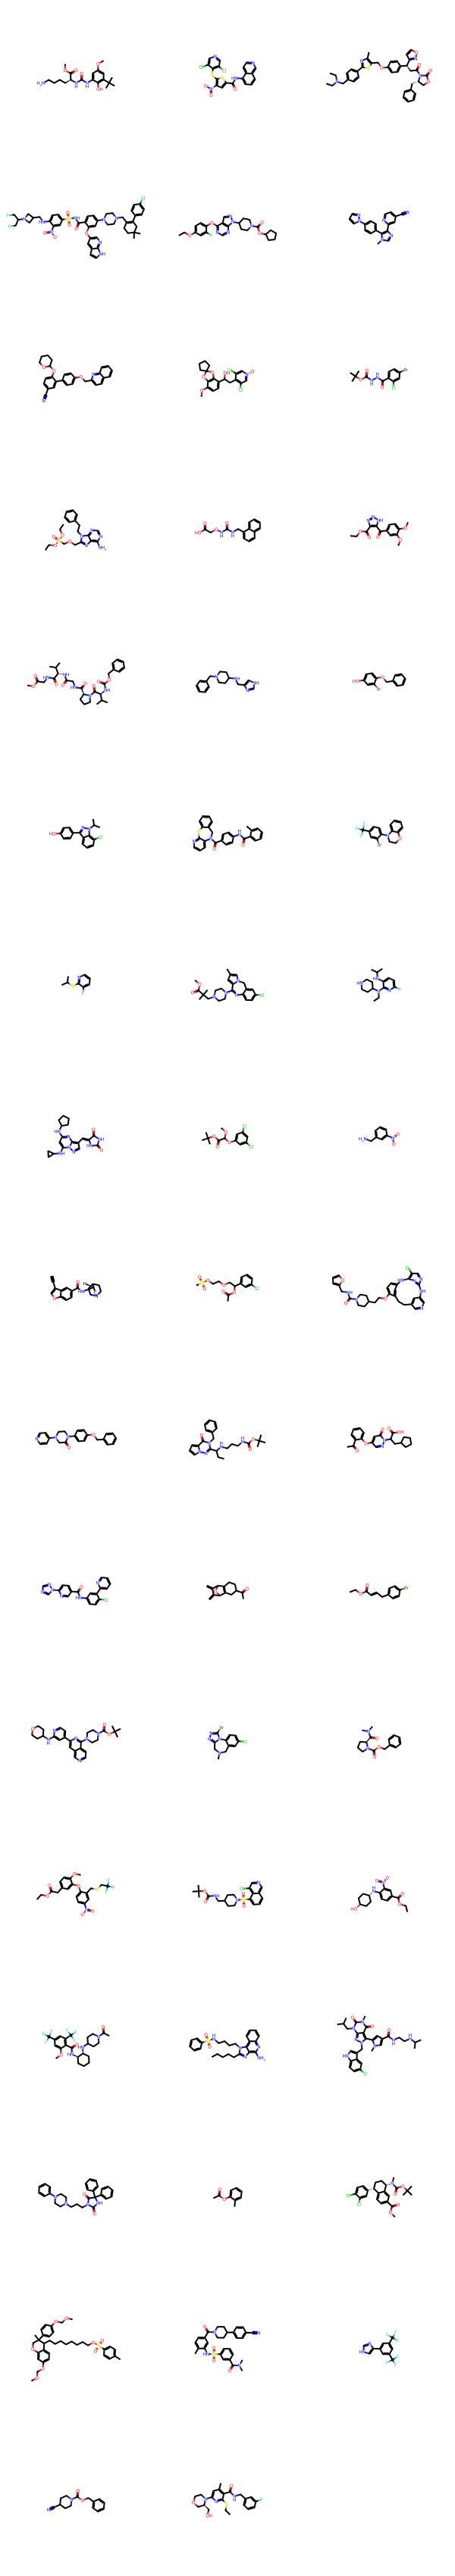

In [233]:
df_50k_split['Molecule 3'] = df_50k_split['Product'].apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

mols = df_50k_split['Molecule 3'].tolist() 

img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(200, 200))

display(img)

In [204]:
functional_groups = {
    # Carbon functional groups
    'alkane': '[CX4]',
    'allenic_carbon': '[$([CX2](=C)=C)]',
    'vinylic_carbon': '[$([CX3]=[CX3])]',
    'ethenyl_carbon': 'C=C',
    'acetylenic_carbon': '[$([CX2]#C)]',
    'arene': 'c',

    # Carbonyl groups
    'carbonyl': '[CX3]=[OX1]',
    'carbonyl_resonance': '[$([CX3]=[OX1]),$([CX3+]-[OX1-])]',
    'carbonyl_with_carbon': '[CX3](=[OX1])C',
    'carbonyl_with_nitrogen': '[OX1]=CN',
    'carbonyl_with_oxygen': '[CX3](=[OX1])O',
    'acyl_halide': '[CX3](=[OX1])[F,Cl,Br,I]',
    'aldehyde': '[CX3H1](=O)[#6]',
    'anhydride': '[CX3](=[OX1])[OX2][CX3](=[OX1])',
    'amide': '[NX3][CX3](=[OX1])[#6]',
    'amidinium': '[NX3][CX3]=[NX3+]',
    'carbamate': '[NX3,NX4+][CX3](=[OX1])[OX2,OX1-]',
    'carbamic_ester': '[NX3][CX3](=[OX1])[OX2H0]',
    'carbamic_acid': '[NX3,NX4+][CX3](=[OX1])[OX2H,OX1-]',
    'carboxylate_ion': '[CX3](=O)[O-]',
    'carbonic_acid_or_ester': '[CX3](=[OX1])(O)O',
    'carbonic_acid_or_conjugate_base': '[CX3](=O)[OX1H0-,OX2H1]',
    'carbonic_ester': 'C[OX2][CX3](=[OX1])[OX2]C',
    'carboxylic_acid': '[CX3](=O)[OX2H1]',
    'cyanamide': '[NX3][CX2]#[NX1]',
    'ester': '[#6][CX3](=O)[OX2H0][#6]',
    'ketone': '[#6][CX3](=O)[#6]',

    # Ether group
    'ether': '[OD2]([#6])[#6]',

    # Hydrogen atoms
    'hydrogen_atom': '[H]',
    'proton': '[H+]',
    'not_a_hydrogen_atom': '[!#1]',

    # Nitrogen functional groups
    'amine': '[NX3;H2,H1;!$(NC=O)]',
    'enamine': '[NX3][CX3]=[CX3]',
    'primary_amine': '[NX3;H2;!$(NC=[!#6]);!$(NC#[!#6])][#6]',
    'imine': '[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]',
    'iminium': '[NX3+]=[CX3]',
    'amide_group': '[NX3][CX3](=[OX1])[#6]',

    # Oxygen functional groups
    'hydroxyl': '[OX2H]',
    'alcohol_hydroxyl': '[#6][OX2H]',
    'carboxylic_acid_hydroxyl': '[OX2H][CX3]=[OX1]',
    'phenol': '[OX2H][cX3]:[c]',
    'acidic_hydroxyl': '[$([OH]-*=[!#6])]',
    'peroxide': '[OX2,OX1-][OX2,OX1-]',

    # Phosphorus functional groups
    'phosphoric_acid': '[$(P(=[OX1])([$([OX2H]),$([OX1-]),$([OX2]P)])([$([OX2H]),$([OX1-]),$([OX2]P)])[$([OX2H]),$([OX1-]),$([OX2]P)])]',
    'phosphoric_ester': '[$(P(=[OX1])([OX2][#6])([$([OX2H]),$([OX1-]),$([OX2][#6])])[$([OX2H]),$([OX1-]),$([OX2][#6]),$([OX2]P)])]',

    # Sulfur functional groups
    'thiol_sulfide_or_disulfide': '[SX2]',
    'thiol': '[#16X2H]',
    'disulfide': '[#16X2H0][#16X2H0]',
    'sulfide': '[#16X2H0]',
    'sulfinate': '[$([#16X3](=[OX1])[OX2H0]),$([#16X3+]([OX1-])[OX2H0])]',
    'sulfoxide': '[$([#16X3]=[OX1]),$([#16X3+][OX1-])]',
    'sulfonic_acid': '[$([#16X4](=[OX1])(=[OX1])([#6])[OX2H,OX1H0-])]',
    'sulfonamide': '[$([#16X4]([NX3])(=[OX1])(=[OX1])[#6]),$([#16X4+2]([NX3])([OX1-])([OX1-])[#6])]',
    
    # Halogen functional groups
    'halide': '[F,Cl,Br,I]',
    'acyl_halide': '[CX3](=[OX1])[F,Cl,Br,I]',
    'three_halides': '[F,Cl,Br,I].[F,Cl,Br,I].[F,Cl,Br,I]',

    # Nitrogen functional groups
    'nitrate': '[$([NX3](=[OX1])(=[OX1])O),$([NX3+]([OX1-])(=[OX1])O)]',
    'nitrile': '[NX1]#[CX2]',
    'imine_group': '[CX3;$([C]([#6])[#6]),$([CH][#6])]=[NX2][#6]',
    'nitro': '[$([NX3](=O)=O),$([NX3+](=O)[O-])]',
    'nitroso': '[NX2]=[OX1]',
    'azide': '[$(*-[NX2-]-[NX2+]#[NX1]),$(*-[NX2]=[NX2+]=[NX1-])]',
    
    # Amino Acids
    'amino_acid': '[$([NX3H2,NX4H3+]),$([NX3H](C)(C))][CX4H]([*])[CX3](=[OX1])[OX2H,OX1-,N]',
    'alanine_side_chain': '[CH3X4]',
    'arginine_side_chain': '[CH2X4][CH2X4][CH2X4][NHX3][CH0X3](=[NH2X3+,NHX2+0])[NH2X3]',
    'glycine': 'N[CX4H2][CX3](=[OX1])[O,N]',
    'phenylalanine_side_chain': '[CH2X4][cX3]1[cX3H][cX3H][cX3H][cX3H][cX3H]1',
}

In [207]:
def extract_functional_groups(smiles):
    if smiles is None or pd.isna(smiles):  
        return {}
    
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is None:  
        return {}
    
    fg_vector = {}
    for group_name, smarts in functional_groups_smarts.items():
        group_pattern = Chem.MolFromSmarts(smarts)
        fg_vector[group_name] = int(molecule.HasSubstructMatch(group_pattern))
    
    return fg_vector

In [208]:
df_50k_split['Reactant 1 FG'] = df_50k_split['Reactant 1'].apply(extract_functional_groups)
df_50k_split['Reactant 2 FG'] = df_50k_split['Reactant 2'].apply(extract_functional_groups)
df_50k_split['Product FG'] = df_50k_split['Product'].apply(extract_functional_groups)

In [209]:
df_50k_split

,Reactant 1,Reactant 2,Product,Reactant 1 FG,Reactant 2 FG,Product FG
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,None,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...",{},"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
1,Nc1cccc2cnccc12,O=C(O)c1cc([N+](=O)[O-])c(Sc2c(Cl)cncc2Cl)s1,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,"{'alkane': 0, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 0, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 0, 'allenic_carbon': 0, 'vinylic_ca..."
2,CCNCC,Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC(=O)N2...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,O=C(CF)CF,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1,O=C(Cl)OC1CCCC1,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
...,...,...,...,...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,None,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...",{},"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 0, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O,NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 0, 'allenic_carbon': 0, 'vinylic_ca...","{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,None,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1,"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca...",{},"{'alkane': 1, 'allenic_carbon': 0, 'vinylic_ca..."


## 3. Testing causal inference on functional groups

In [210]:
reactant_1_fg_df = pd.json_normalize(df_50k_split['Reactant 1 FG'])
reactant_2_fg_df = pd.json_normalize(df_50k_split['Reactant 2 FG'])
product_fg_df = pd.json_normalize(df_50k_split['Product FG'])

In [211]:
features_df = pd.concat([reactant_1_fg_df, reactant_2_fg_df], axis=1)
outcome_df = product_fg_df

In [212]:
all_functional_groups = sorted(set(features_df.columns) | set(outcome_df.columns))
print("List of functional groups (nodes for the DAG):")
print(all_functional_groups)

List of functional groups (nodes for the DAG):
['acetylenic_carbon', 'acidic_hydroxyl', 'acyl_halide', 'alanine_side_chain', 'alcohol_hydroxyl', 'aldehyde', 'alkane', 'allenic_carbon', 'amide', 'amide_group', 'amidinium', 'amine', 'amino_acid', 'anhydride', 'arene', 'arginine_side_chain', 'azide', 'carbamate', 'carbamic_acid', 'carbamic_ester', 'carbonic_acid_or_conjugate_base', 'carbonic_acid_or_ester', 'carbonic_ester', 'carbonyl', 'carbonyl_resonance', 'carbonyl_with_carbon', 'carbonyl_with_nitrogen', 'carbonyl_with_oxygen', 'carboxylate_ion', 'carboxylic_acid', 'carboxylic_acid_hydroxyl', 'cyanamide', 'disulfide', 'enamine', 'ester', 'ethenyl_carbon', 'ether', 'glycine', 'halide', 'hydrogen_atom', 'hydroxyl', 'imine', 'imine_group', 'iminium', 'ketone', 'nitrate', 'nitrile', 'nitro', 'nitroso', 'not_a_hydrogen_atom', 'peroxide', 'phenol', 'phenylalanine_side_chain', 'phosphoric_acid', 'phosphoric_ester', 'primary_amine', 'proton', 'sulfide', 'sulfinate', 'sulfonamide', 'sulfonic_ac

In [35]:
#df_50k_split.to_csv('temp.csv', index=False)

In [69]:
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = mfpgen.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=np.int32)
        ConvertToNumpyArray(fp, arr)
        return arr
    else:
        return None

In [79]:
df_50k_split['Reactant_Fingerprint'] = df_50k_split['Reactant'].apply(smiles_to_fingerprint)
df_50k_split['Product_Fingerprint'] =df_50k_split['Product'].apply(smiles_to_fingerprint)

In [80]:
df_50k_split

,Reactant,Product,Reactant_Fingerprint,Product_Fingerprint
0,COC(=O)[C@H](CCCCNC(=O)OCc1ccccc1)NC(=O)Nc1cc(...,COC(=O)[C@H](CCCCN)NC(=O)Nc1cc(OC)cc(C(C)(C)C)c1O,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Nc1cccc2cnccc12.O=C(O)c1cc([N+](=O)[O-])c(Sc2c...,O=C(Nc1cccc2cnccc12)c1cc([N+](=O)[O-])c(Sc2c(C...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CCNCC.Cc1nc(-c2ccc(C=O)cc2)sc1COc1ccc([C@H](CC...,CCN(CC)Cc1ccc(-c2nc(C)c(COc3ccc([C@H](CC(=O)N4...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,CC1(C)CCC(CN2CCN(c3ccc(C(=O)NS(=O)(=O)c4ccc(NC...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CCOc1ccc(Oc2ncnc3c2cnn3C2CCNCC2)c(F)c1.O=C(Cl)...,CCOc1ccc(Oc2ncnc3c2cnn3C2CCN(C(=O)OC3CCCC3)CC2...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
50011,CCOC(=O)N1CCc2ccc3c(c2CC1)C(O)(C1CC1)CC3,CCOC(=O)N1CCc2ccc3c(c2CC1)C(C1CC1)CC3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
50012,Brc1cccc(C=C2c3ccccc3CCc3ccccc32)c1.N#C[Cu],N#Cc1cccc(C=C2c3ccccc3CCc3ccccc32)c1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
50013,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=O.NO,Cc1noc(C)c1-c1c(-c2ccc(O)cc2)c2ccccc2n1C=NO,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
50014,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nc(Br)cn23)cc1,O=C(NC1CC1)c1ccc(-c2cnc3c(NCCCO)nccn23)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."


In [83]:
df_50k_fps = df_50k_split.iloc[:,2:]

In [84]:
df_reagents = df_50k_split['Reactant_Fingerprint']
df_products = df_50k_split[ 'Product_Fingerprint']

In [133]:
data_array = df_50k_split.iloc[:,2:]

In [149]:
data_array = data_array.to_numpy()

In [150]:
data_array

array([[array([0, 1, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 1, 0, ..., 0, 0, 0], dtype=int32)],
       [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 0, 0, ..., 0, 0, 0], dtype=int32)],
       [array([0, 1, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 1, 0, ..., 0, 0, 0], dtype=int32)],
       ...,
       [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 0, 0, ..., 0, 0, 0], dtype=int32)],
       [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 0, 0, ..., 0, 0, 0], dtype=int32)],
       [array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
        array([0, 0, 0, ..., 0, 0, 0], dtype=int32)]], dtype=object)

In [120]:
import causallearn
print(dir(causallearn))

import causallearn.search
print(dir(causallearn.search))

import causallearn.utils
print(dir(causallearn.utils))


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'graph', 'search', 'utils']
['ConstraintBased', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']
['GraphUtils', 'KCI', 'PCUtils', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'cit']


In [121]:
from causallearn.search.ConstraintBased import PC


In [122]:
import causallearn.utils as utils


In [128]:
import causallearn.search.ConstraintBased as cb

In [138]:
print(dir(cb))

['PC', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__']


In [139]:
import causallearn.search.ConstraintBased.PC as pc_module
print(dir(pc_module))


['BackgroundKnowledge', 'CIT', 'CIT_Base', 'CONST_BINCOUNT_UNIQUE_THRESHOLD', 'CausalGraph', 'Chisq_or_Gsq', 'D_Separation', 'Dict', 'FisherZ', 'Helper', 'Iterable', 'KCI', 'KCI_CInd', 'KCI_UInd', 'List', 'MC_FisherZ', 'MV_FisherZ', 'Meek', 'NO_SPECIFIED_PARAMETERS_MSG', 'SkeletonDiscovery', 'Tuple', 'UCSepset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'annotations', 'chi2', 'chisq', 'codecs', 'combinations', 'd_separation', 'detect_parent', 'fisherz', 'get_adjacancy_matrix', 'get_missingness_index', 'get_parent', 'get_parent_missingness_pairs', 'gsq', 'hashlib', 'isempty', 'json', 'kci', 'log', 'matrix_diff', 'mc_fisherz', 'mv_fisherz', 'mvpc_alg', 'ndarray', 'norm', 'np', 'nx', 'orient_by_background_knowledge', 'os', 'pc', 'pc_alg', 'permutations', 'skeleton_correction', 'sqrt', 'time', 'warnings']


In [144]:
from causallearn.search.ConstraintBased import PC

print(dir(PC))


['BackgroundKnowledge', 'CIT', 'CIT_Base', 'CONST_BINCOUNT_UNIQUE_THRESHOLD', 'CausalGraph', 'Chisq_or_Gsq', 'D_Separation', 'Dict', 'FisherZ', 'Helper', 'Iterable', 'KCI', 'KCI_CInd', 'KCI_UInd', 'List', 'MC_FisherZ', 'MV_FisherZ', 'Meek', 'NO_SPECIFIED_PARAMETERS_MSG', 'SkeletonDiscovery', 'Tuple', 'UCSepset', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'annotations', 'chi2', 'chisq', 'codecs', 'combinations', 'd_separation', 'detect_parent', 'fisherz', 'get_adjacancy_matrix', 'get_missingness_index', 'get_parent', 'get_parent_missingness_pairs', 'gsq', 'hashlib', 'isempty', 'json', 'kci', 'log', 'matrix_diff', 'mc_fisherz', 'mv_fisherz', 'mvpc_alg', 'ndarray', 'norm', 'np', 'nx', 'orient_by_background_knowledge', 'os', 'pc', 'pc_alg', 'permutations', 'skeleton_correction', 'sqrt', 'time', 'warnings']


In [145]:
print([attr for attr in dir(PC) if callable(getattr(PC, attr))])


['BackgroundKnowledge', 'CIT', 'CIT_Base', 'CausalGraph', 'Chisq_or_Gsq', 'D_Separation', 'Dict', 'FisherZ', 'Iterable', 'KCI', 'KCI_CInd', 'KCI_UInd', 'List', 'MC_FisherZ', 'MV_FisherZ', 'Tuple', 'chi2', 'combinations', 'detect_parent', 'get_adjacancy_matrix', 'get_missingness_index', 'get_parent', 'get_parent_missingness_pairs', 'isempty', 'log', 'matrix_diff', 'mvpc_alg', 'ndarray', 'norm', 'orient_by_background_knowledge', 'pc', 'pc_alg', 'permutations', 'skeleton_correction', 'sqrt']


In [146]:
print(dir(PC.pc_alg))


['__annotations__', '__builtins__', '__call__', '__class__', '__closure__', '__code__', '__defaults__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__get__', '__getattribute__', '__getstate__', '__globals__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__kwdefaults__', '__le__', '__lt__', '__module__', '__name__', '__ne__', '__new__', '__qualname__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [147]:
help(PC.pc_alg)


Help on function pc_alg in module causallearn.search.ConstraintBased.PC:

pc_alg(data: 'ndarray', node_names: 'List[str] | None', alpha: 'float', indep_test: 'str', stable: 'bool', uc_rule: 'int', uc_priority: 'int', background_knowledge: 'BackgroundKnowledge | None' = None, verbose: 'bool' = False, show_progress: 'bool' = True, **kwargs) -> 'CausalGraph'
    Perform Peter-Clark (PC) algorithm for causal discovery
    
    Parameters
    ----------
    data : data set (numpy ndarray), shape (n_samples, n_features). The input data, where n_samples is the number of samples and n_features is the number of features.
    node_names: Shape [n_features]. The name for each feature (each feature is represented as a Node in the graph, so it's also the node name)
    alpha : float, desired significance level of independence tests (p_value) in (0, 1)
    indep_test : str, the name of the independence test being used
            ["fisherz", "chisq", "gsq", "kci"]
           - "fisherz": Fisher's Z 

In [148]:
import numpy as np
from causallearn.search.ConstraintBased.PC import pc_alg

In [ ]:
node_names = ['A', 'B', 'C']

if not isinstance(data_array, np.ndarray):
    data_array = np.array(data_array, dtype=float)
else:
    data_array = data_array.astype(float)

causal_graph = pc_alg(
    data=data_array,
    node_names=node_names,
    alpha=0.05,
    indep_test='fisherz',
    stable=True,
    uc_rule=1,
    uc_priority=0,
    verbose=True,
    show_progress=True
)

print(causal_graph)
